In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Machine Learning
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

#HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# F2 score for gridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

In [2]:
t_data = pd.read_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\telecom_data.csv', encoding='euc-kr',engine='python')
t_data.rename(columns= t_data.iloc[0],inplace=True)
t_data.drop(t_data.index[0],axis=0,inplace=True)

#### 전처리

In [3]:
#결측치 처리
t_data['TotalCharges'] = t_data['TotalCharges'].replace(" ",np.nan)
t_data.dropna(inplace=True)
t_data.drop('customerID',axis=1,inplace=True)

#타입 변경
col1 = ['MonthlyCharges','TotalCharges']
for i in col1:
    t_data[i] = t_data[i].astype(float)

t_data['tenure'] = t_data['tenure'].astype(int)
t_data.dtypes

#이탈 여부 표현
t_data.loc[t_data.Churn == 'No','Churn'] = 0
t_data.loc[t_data.Churn == 'Yes', 'Churn'] = 1
t_data.Churn = t_data.Churn.astype(int)

#### 가정) Monthly Charge와 Total Charge 값의 단위를 만원으로 나타내기 위해 10으로 나눠줌

In [4]:
t_data['MonthlyCharges'] = t_data['MonthlyCharges']/10
t_data['TotalCharges'] = t_data['TotalCharges']/10

#### 집단 4개로 나누기 - 중간값 기준

In [5]:
group_1 = t_data[(t_data['MonthlyCharges'] < t_data['MonthlyCharges'].median()) & (t_data['tenure'] < t_data['tenure'].median())]
group_2 = t_data[(t_data['MonthlyCharges'] < t_data['MonthlyCharges'].median()) & (t_data['tenure'] > t_data['tenure'].median())]
group_3 = t_data[(t_data['MonthlyCharges'] > t_data['MonthlyCharges'].median()) & (t_data['tenure'] < t_data['tenure'].median())]
group_4 = t_data[(t_data['MonthlyCharges'] > t_data['MonthlyCharges'].median()) & (t_data['tenure'] > t_data['tenure'].median())]

group = [group_1,group_2,group_3,group_4]

print('그룹 1 : 낮은 요금제, 짧은 임기')
print('그룹 2 : 낮은 요금제, 긴 임기')
print('그룹 3 : 높은 요금제, 짧은 임기')
print('그룹 4 : 높은 요금제, 긴 임기')

그룹 1 : 낮은 요금제, 짧은 임기
그룹 2 : 낮은 요금제, 긴 임기
그룹 3 : 높은 요금제, 짧은 임기
그룹 4 : 높은 요금제, 긴 임기


In [6]:
# 이름 출력을 위한 함수
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# 해당 집단의 평균 사용 요금제, 임기, 사람 수
def group_info(data):
    print('name : {}'.format(namestr(data, globals())[0]))
    print('average monthly charge : {:.5f}'.format(data['MonthlyCharges'].mean()))
    print('average tenure : {:.5f}'.format(data['tenure'].mean()))
    print('number of people : {}\n'.format(data.shape[0]))
    return round(data['MonthlyCharges'].mean(),5), round(data['tenure'].mean(),5), data.shape[0]

In [7]:
group1_MC, group1_TN, group1_num = group_info(group_1)
group2_MC, group2_TN, group2_num = group_info(group_2)
group3_MC, group3_TN, group3_num = group_info(group_3)
group4_MC, group4_TN, group4_num = group_info(group_4)

name : group_1
average monthly charge : 3.90229
average tenure : 9.83839
number of people : 2042

name : group_2
average monthly charge : 3.88353
average tenure : 52.99790
number of people : 1430

name : group_3
average monthly charge : 8.55252
average tenure : 11.52884
number of people : 1439

name : group_4
average monthly charge : 9.42872
average tenure : 55.49853
number of people : 2040



#### 각 집단별 최적의 재현율과 정밀도 찾기

- 재현율 오류에 대한 손해 : (데이터 수 * (1-재현율)) * (mothly charge * tenure)
- 정밀도 오류에 대한 손해 : (mothly charge * tenure) = (데이터 수 * (1-정밀도)) * 1인당 투자하는 솔루션 비용

- total loss가 가장 적은 지점이 최고 성능, diff loss=0 인 구간이 손익분기점

In [8]:
def loss_point(num, charge, tenure, sol_price, recall, precision):
    recall_loss = round(((num*(1-recall))*(charge*tenure)),5)
    precision_loss = round(((num*(1-precision))*sol_price),5)
    diff_loss = (recall_loss - precision_loss)
    total_loss = (recall_loss + precision_loss)
    
    if diff_loss > 0:
        print('재현율을 더 높여야 합니다.')
        print('재현율 오류에 따른 손해 : {}만원'.format(recall_loss))
        print('정밀도 오류에 따른 손해 : {}만원'.format(precision_loss))
        print('차이 : {:.5f}만원'.format(diff_loss))
    elif diff_loss < 0:
        print('정밀도를 더 높여야 합니다.')
        print('재현율 오류에 따른 손해 : {}만원'.format(recall_loss))
        print('정밀도 오류에 따른 손해 : {}만원'.format(precision_loss))
        print('차이 : {:.5f}'.format(abs(diff_loss)))
    elif diff_loss == 0:
        print('현재 손익분기점 입니다.')
        
    return diff_loss, total_loss

#### One hot encoding

In [9]:
def OHE(data):
    t_data_dummies = data.drop('Churn',axis=1)
    t_data_dummies = pd.get_dummies(t_data_dummies)
    t_data_dummies['Churn'] = data['Churn']
    return t_data_dummies

group_1 = OHE(group_1)
group_2 = OHE(group_2)
group_3 = OHE(group_3)
group_4 = OHE(group_4)

## 모델링

In [10]:
model_box = pd.DataFrame(columns=['logistic','xgboost','lightgbm','catboost'],
                         index = ['accuracy','precision','recall','f1 score','f1.5 score','f2 score','pr_auc','roc_auc'])

In [11]:
def f_score(beta,y_real, y_pred):
    beta = beta
    pr = precision_score(y_real, y_pred)
    re = recall_score(y_real, y_pred)
    score = (1+beta**2)*(pr*re)/((beta**2*pr)+re)
    return score

In [12]:
def evaluate(y_real,y_pred, y_prob):
    acc = accuracy_score(y_real, y_pred)
    pre = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    f2 = f_score(1.5,y_real, y_pred)
    f3 = f_score(2,y_real, y_pred)
    auc1 = average_precision_score(y_real, y_prob)
    auc2 = roc_auc_score(y_real, y_prob)
    
    print('Accuracy : {:.6f}'.format(acc)) #정확도 : 예측이 정답과 얼마나 정확한가
    print('Precision : {:.6f}'.format(pre)) #정밀도 : 예측한 것 중에서 정답의 비율
    print('Recall : {:.6f}'.format(rec)) #재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1)) #정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('F1.5 score : {:.6f}'.format(f2))
    print('F2 score : {:.6f}'.format(f3))
    print('PR curve_auc score : {:.6f}'.format(auc1))
    print('ROC curve_auc score : {:.6f}'.format(auc2))
    print('\nConfusion Matrix : \n {}'.format(confusion_matrix(y_real, y_pred, labels = [1,0]))) # labels를 설정해주지 않으면 순서가 바뀜
    score_list = [acc,pre,rec,f1,f2,f3,auc1,auc2]
    score_box = np.array(score_list)
    return score_box

In [13]:
def precision_recall_thresholds(y_val, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    plt.figure(figsize = (15,5))
    plt.plot(thresholds, recalls[:-1], color = 'red', label = 'recall')
    plt.plot(thresholds, precisions[:-1], color = 'blue', label = 'precision')
    plt.title('thresholds VS recalls VS precisions')
    plt.xlabel('thresholds')
    plt.legend(loc = 'best')

#### 그룹 1 - 낮은 요금제 + 짧은 임기

In [14]:
data = group_1.drop('Churn',axis=1)
target = group_1.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

In [15]:
param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.6min finished


In [16]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

In [17]:
scr = evaluate(y_val,y_pred,y_prob)

Accuracy : 0.597911
Precision : 0.400862
Recall : 0.861111
F1 score : 0.547059
F1.5 score : 0.636316
F2 score : 0.700301
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 93  15]
 [139 136]]


In [18]:
#솔루션 비용 : 할인혜택 + 인건비 + ..등등 / 인당 4만원이라 가정
price = 4
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])

재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 10888.46894만원
정밀도 오류에 따른 손해 : 4893.75862만원
차이 : 5994.71032만원


(5994.710320000001, 15782.22756)

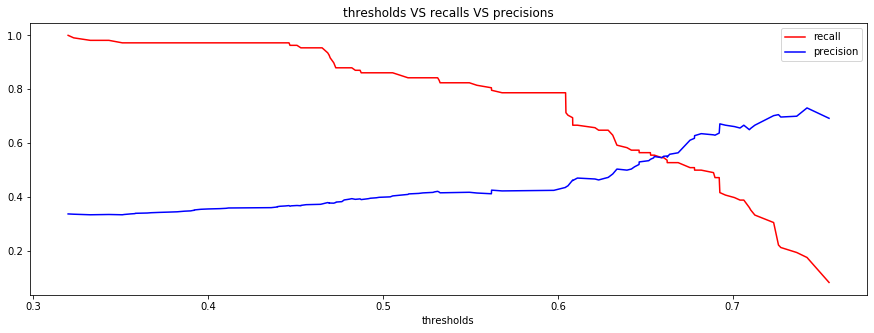

In [19]:
precision_recall_thresholds(y_val, y_prob)

In [20]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.446475
Precision : 0.337500
Recall : 1.000000
F1 score : 0.504673
F1.5 score : 0.623446
F2 score : 0.718085
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[108   0]
 [212  63]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 5411.3만원
차이 : 5411.30000
Accuracy : 0.446475
Precision : 0.336478
Recall : 0.990741
F1 score : 0.502347
F1.5 score : 0.619875
F2 score : 0.713333
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[107   1]
 [211  64]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 725.89793만원
정밀도 오류에 따른 손해 : 5419.6478만원
차이 : 4693.74987
Accuracy : 0.443864
Precision : 0.334385
Recall : 0.981481
F1 score : 0.498824
F1.5 score : 0.615179
F2 score : 0.707610
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[106   2]
 [211  64]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 1451.79586만원
정밀도 오류에 따른 손해 : 5436.74448만원
차이 : 3984.94862
Accuracy : 0.446475
Precision : 0.335443
Recall : 0.981481
F1 

Accuracy : 0.519582
Precision : 0.367133
Recall : 0.972222
F1 score : 0.532995
F1.5 score : 0.645085
F2 score : 0.731198
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[105   3]
 [181  94]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2177.69379만원
정밀도 오류에 따른 손해 : 5169.25874만원
차이 : 2991.56495
Accuracy : 0.522193
Precision : 0.368421
Recall : 0.972222
F1 score : 0.534351
F1.5 score : 0.646307
F2 score : 0.732218
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[105   3]
 [180  95]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2177.69379만원
정밀도 오류에 따른 손해 : 5158.73684만원
차이 : 2981.04305
Accuracy : 0.519582
Precision : 0.366197
Recall : 0.962963
F1 score : 0.530612
F1.5 score : 0.641366
F2 score : 0.726257
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[104   4]
 [180  95]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 2903.59172만원
정밀도 오류에 따른 손해 : 5176.90141만원
차이 : 2273.30969
Accuracy : 0.522193
Precision : 0.367491
Recall :

Accuracy : 0.597911
Precision : 0.400862
Recall : 0.861111
F1 score : 0.547059
F1.5 score : 0.636316
F2 score : 0.700301
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 93  15]
 [139 136]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 10888.46894만원
정밀도 오류에 따른 손해 : 4893.75862만원
차이 : 5994.71032만원
Accuracy : 0.603133
Precision : 0.404348
Recall : 0.861111
F1 score : 0.550296
F1.5 score : 0.639006
F2 score : 0.702417
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 93  15]
 [137 138]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 10888.46894만원
정밀도 오류에 따른 손해 : 4865.28696만원
차이 : 6023.18198만원
Accuracy : 0.613577
Precision : 0.409910
Recall : 0.842593
F1 score : 0.551515
F1.5 score : 0.636022
F2 score : 0.695719
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 91  17]
 [131 144]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 12340.2648만원
정밀도 오류에 따른 손해 : 4819.85586만원
차이 : 7520.40894만원
Accuracy : 0.616188
Precision : 0.411765



Confusion Matrix : 
 [[ 62  46]
 [ 57 218]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 33391.30475만원
정밀도 오류에 따른 손해 : 3912.40336만원
차이 : 29478.90139만원
Accuracy : 0.736292
Precision : 0.530435
Recall : 0.564815
F1 score : 0.547085
F1.5 score : 0.553771
F2 score : 0.557587
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 61  47]
 [ 54 221]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 34117.20268만원
정밀도 오류에 따른 손해 : 3835.4087만원
차이 : 30281.79398만원
Accuracy : 0.738903
Precision : 0.535088
Recall : 0.564815
F1 score : 0.549550
F1.5 score : 0.555322
F2 score : 0.558608
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 61  47]
 [ 53 222]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 34117.20268만원
정밀도 오류에 따른 손해 : 3797.40351만원
차이 : 30319.79917만원
Accuracy : 0.741514
Precision : 0.539823
Recall : 0.564815
F1 score : 0.552036
F1.5 score : 0.556882
F2 score : 0.559633
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 61  47]
 [ 52

Accuracy : 0.749347
Precision : 0.730769
Recall : 0.175926
F1 score : 0.283582
F1.5 score : 0.229554
F2 score : 0.207424
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[ 19  89]
 [  7 268]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 64604.91571만원
정밀도 오류에 따른 손해 : 2199.07692만원
차이 : 62405.83879만원
Accuracy : 0.731070
Precision : 0.692308
Recall : 0.083333
F1 score : 0.148760
F1.5 score : 0.114258
F2 score : 0.101124
PR curve_auc score : 0.564438
ROC curve_auc score : 0.776313

Confusion Matrix : 
 [[  9  99]
 [  4 271]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 71863.895만원
정밀도 오류에 따른 손해 : 2513.23077만원
차이 : 69350.66423만원


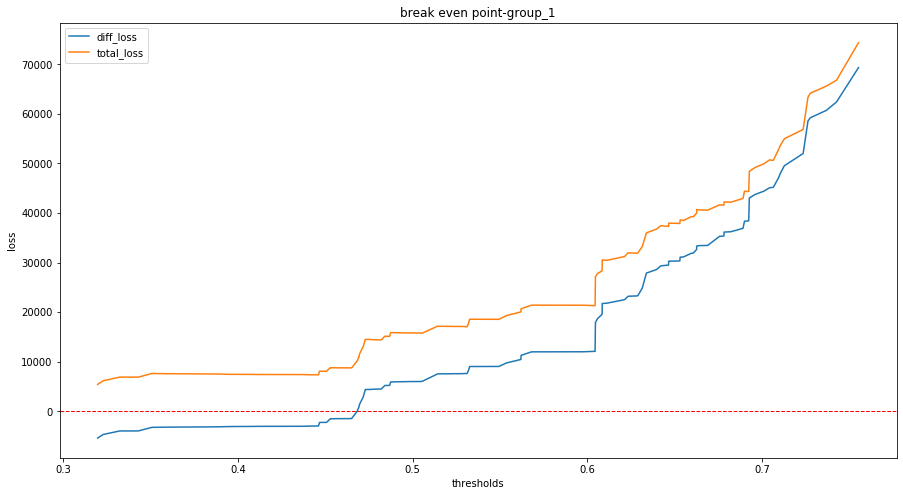

In [21]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_1')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 1에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 2 - 낮은 요금제 + 긴 임기

In [22]:
data = group_2.drop('Churn',axis=1)
target = group_2.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.1min finished


Accuracy : 0.899254
Precision : 0.150000
Recall : 0.230769
F1 score : 0.181818
F1.5 score : 0.197970
F2 score : 0.208333
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  3  10]
 [ 17 238]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 60305.36643만원
정밀도 오류에 따른 손해 : 6942.8만원
차이 : 53362.56643만원


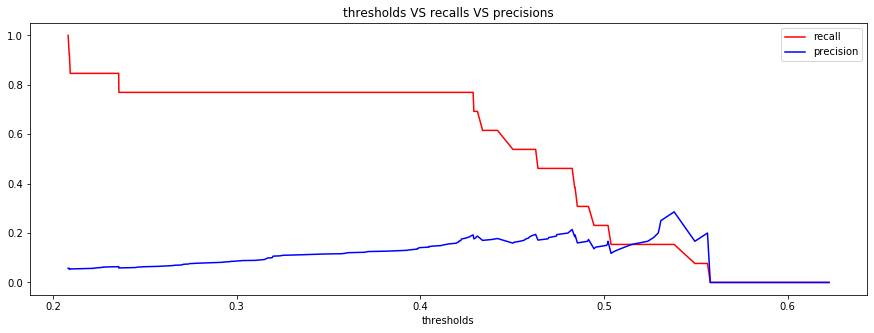

In [23]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [24]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.205224
Precision : 0.057522
Recall : 1.000000
F1 score : 0.108787
F1.5 score : 0.165524
F2 score : 0.233813
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 13   0]
 [213  42]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 7698.15929만원
차이 : 7698.15929
Accuracy : 0.216418
Precision : 0.054299
Recall : 0.923077
F1 score : 0.102564
F1.5 score : 0.155844
F2 score : 0.219780
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 12   1]
 [209  46]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 6030.53664만원
정밀도 오류에 따른 손해 : 7724.48869만원
차이 : 1693.95205
Accuracy : 0.261194
Precision : 0.057416
Recall : 0.923077
F1 score : 0.108108
F1.5 score : 0.163694
F2 score : 0.229885
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 12   1]
 [197  58]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 6030.53664만원
정밀도 오류에 따른 손해 : 7699.02392만원
차이 : 1668.48728
Accuracy : 0.272388
Precision : 0.053922
Recall : 0.8461


Confusion Matrix : 
 [[ 10   3]
 [160  95]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7687.52941만원
차이 : 10404.08052만원
Accuracy : 0.395522
Precision : 0.059172
Recall : 0.769231
F1 score : 0.109890
F1.5 score : 0.163934
F2 score : 0.226244
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [159  96]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7684.68639만원
차이 : 10406.92354만원
Accuracy : 0.399254
Precision : 0.059524
Recall : 0.769231
F1 score : 0.110497
F1.5 score : 0.164766
F2 score : 0.227273
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [158  97]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7681.80952만원
차이 : 10409.80041만원
Accuracy : 0.402985
Precision : 0.059880
Recall : 0.769231
F1 score : 0.111111
F1.5 score : 0.165605
F2 score : 0.228311
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [15

Accuracy : 0.507463
Precision : 0.071942
Recall : 0.769231
F1 score : 0.131579
F1.5 score : 0.193165
F2 score : 0.261780
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [129 126]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7580.3741만원
차이 : 10511.23583만원
Accuracy : 0.511194
Precision : 0.072464
Recall : 0.769231
F1 score : 0.132450
F1.5 score : 0.194320
F2 score : 0.263158
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [128 127]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7576.11594만원
차이 : 10515.49399만원
Accuracy : 0.514925
Precision : 0.072993
Recall : 0.769231
F1 score : 0.133333
F1.5 score : 0.195489
F2 score : 0.264550
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [127 128]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7571.79562만원
차이 : 10519.81431만원
Accuracy : 0.518657
Precision : 0.0735

Recall : 0.769231
F1 score : 0.196078
F1.5 score : 0.274841
F2 score : 0.354610
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 79 176]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7250.24719만원
차이 : 10841.36274만원
Accuracy : 0.701493
Precision : 0.114943
Recall : 0.769231
F1 score : 0.200000
F1.5 score : 0.279570
F2 score : 0.359712
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 77 178]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7229.14943만원
차이 : 10862.46050만원
Accuracy : 0.705224
Precision : 0.116279
Recall : 0.769231
F1 score : 0.202020
F1.5 score : 0.281996
F2 score : 0.362319
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 76 179]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 7218.23256만원
차이 : 10873.37737만원
Accuracy : 0.708955
Precision : 0.117647
Recall : 0.769231
F1 score : 0.204082

Accuracy : 0.805970
Precision : 0.169492
Recall : 0.769231
F1 score : 0.277778
F1.5 score : 0.368272
F2 score : 0.450450
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 49 206]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 6783.59322만원
차이 : 11308.01671만원
Accuracy : 0.813433
Precision : 0.175439
Recall : 0.769231
F1 score : 0.285714
F1.5 score : 0.376812
F2 score : 0.458716
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 47 208]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 6735.01754만원
차이 : 11356.59239만원
Accuracy : 0.817164
Precision : 0.178571
Recall : 0.769231
F1 score : 0.289855
F1.5 score : 0.381232
F2 score : 0.462963
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[ 10   3]
 [ 46 209]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 18091.60993만원
정밀도 오류에 따른 손해 : 6709.42857만원
차이 : 11382.18136만원
Accuracy : 0.820896
Precision : 0.181

재현율 오류에 따른 손해 : 42213.7565만원
정밀도 오류에 따른 손해 : 6587.09677만원
차이 : 35626.65973만원
Accuracy : 0.884328
Precision : 0.200000
Recall : 0.461538
F1 score : 0.279070
F1.5 score : 0.329114
F2 score : 0.365854
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  6   7]
 [ 24 231]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 42213.7565만원
정밀도 오류에 따른 손해 : 6534.4만원
차이 : 35679.35650만원
Accuracy : 0.891791
Precision : 0.214286
Recall : 0.461538
F1 score : 0.292683
F1.5 score : 0.340611
F2 score : 0.375000
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  6   7]
 [ 22 233]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 42213.7565만원
정밀도 오류에 따른 손해 : 6417.71429만원
차이 : 35796.04221만원
Accuracy : 0.888060
Precision : 0.185185
Recall : 0.384615
F1 score : 0.250000
F1.5 score : 0.288889
F2 score : 0.316456
PR curve_auc score : 0.166447
ROC curve_auc score : 0.758824

Confusion Matrix : 
 [[  5   8]
 [ 22 233]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 48244.29315만원
정밀도 오류에 따른 손해 

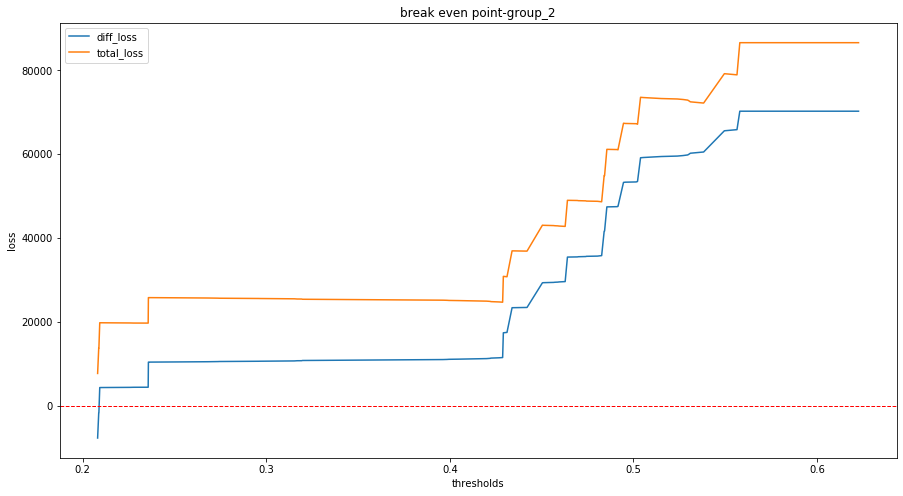

In [25]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_2')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 2에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 3 - 높은 요금제 + 짧은 임기

In [26]:
data = group_3.drop('Churn',axis=1)
target = group_3.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.2min finished


Accuracy : 0.533333
Precision : 0.526923
Recall : 0.978571
F1 score : 0.685000
F1.5 score : 0.774348
F2 score : 0.835366
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[137   3]
 [123   7]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 1679.93521만원
정밀도 오류에 따른 손해 : 38640.92308만원
차이 : 36960.98787


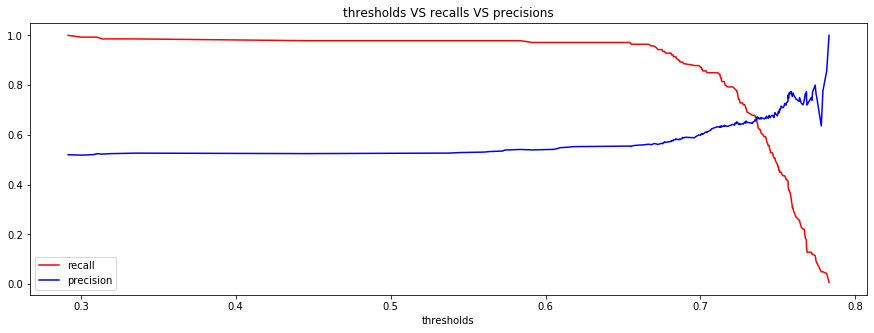

In [27]:
price = 40 #솔루션 비용 40
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [28]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.522222
Precision : 0.520446
Recall : 1.000000
F1 score : 0.684597
F1.5 score : 0.779110
F2 score : 0.844391
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[140   0]
 [129   1]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 39169.96283만원
차이 : 39169.96283
Accuracy : 0.518519
Precision : 0.518657
Recall : 0.992857
F1 score : 0.681373
F1.5 score : 0.774871
F2 score : 0.839372
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[139   1]
 [129   1]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 559.9784만원
정밀도 오류에 따른 손해 : 39316.1194만원
차이 : 38756.14100
Accuracy : 0.522222
Precision : 0.520599
Recall : 0.992857
F1 score : 0.683047
F1.5 score : 0.776203
F2 score : 0.840387
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[139   1]
 [128   2]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 559.9784만원
정밀도 오류에 따른 손해 : 39157.45318만원
차이 : 38597.47478
Accuracy : 0.525926
Precision : 0.522556
Recall : 0.992


Confusion Matrix : 
 [[134   6]
 [105  25]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 3359.87042만원
정밀도 오류에 따른 손해 : 35884.51883만원
차이 : 32524.64841
Accuracy : 0.592593
Precision : 0.563025
Recall : 0.957143
F1 score : 0.708995
F1.5 score : 0.787523
F2 score : 0.839599
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[134   6]
 [104  26]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 3359.87042만원
정밀도 오류에 따른 손해 : 35692.10084만원
차이 : 32332.23042
Accuracy : 0.596296
Precision : 0.565401
Recall : 0.957143
F1 score : 0.710875
F1.5 score : 0.788949
F2 score : 0.840652
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[134   6]
 [103  27]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 3359.87042만원
정밀도 오류에 따른 손해 : 35498.05907만원
차이 : 32138.18865
Accuracy : 0.592593
Precision : 0.563559
Recall : 0.950000
F1 score : 0.707447
F1.5 score : 0.784483
F2 score : 0.835427
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[133   7]
 [103  27]


Confusion Matrix : 
 [[122  18]
 [ 81  49]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 10079.61125만원
정밀도 오류에 따른 손해 : 32591.52709만원
차이 : 22511.91584
Accuracy : 0.637037
Precision : 0.603960
Recall : 0.871429
F1 score : 0.713450
F1.5 score : 0.766925
F2 score : 0.800525
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[122  18]
 [ 80  50]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 10079.61125만원
정밀도 오류에 따른 손해 : 32348.51485만원
차이 : 22268.90360
Accuracy : 0.633333
Precision : 0.601990
Recall : 0.864286
F1 score : 0.709677
F1.5 score : 0.762112
F2 score : 0.795007
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[121  19]
 [ 80  50]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 10639.58965만원
정밀도 오류에 따른 손해 : 32509.45274만원
차이 : 21869.86309
Accuracy : 0.637037
Precision : 0.605000
Recall : 0.864286
F1 score : 0.711765
F1.5 score : 0.763592
F2 score : 0.796053
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[121  19]
 [ 79  

Accuracy : 0.662963
Precision : 0.641618
Recall : 0.792857
F1 score : 0.709265
F1.5 score : 0.739242
F2 score : 0.757162
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[111  29]
 [ 62  68]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 16239.37368만원
정밀도 오류에 따른 손해 : 29272.60116만원
차이 : 13033.22748
Accuracy : 0.659259
Precision : 0.639535
Recall : 0.785714
F1 score : 0.705128
F1.5 score : 0.734086
F2 score : 0.751366
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[110  30]
 [ 62  68]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 16799.35208만원
정밀도 오류에 따른 손해 : 29442.7907만원
차이 : 12643.43862
Accuracy : 0.666667
Precision : 0.647059
Recall : 0.785714
F1 score : 0.709677
F1.5 score : 0.737113
F2 score : 0.753425
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[110  30]
 [ 60  70]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 16799.35208만원
정밀도 오류에 따른 손해 : 28828.23529만원
차이 : 12028.88321
Accuracy : 0.662963
Precision : 0.644970


 [48 82]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 26318.98492만원
정밀도 오류에 따른 손해 : 27805.95745만원
차이 : 1486.97253
Accuracy : 0.651852
Precision : 0.664286
Recall : 0.664286
F1 score : 0.664286
F1.5 score : 0.664286
F2 score : 0.664286
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[93 47]
 [47 83]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 26318.98492만원
정밀도 오류에 따른 손해 : 27421.14286만원
차이 : 1102.15794
Accuracy : 0.655556
Precision : 0.669065
Recall : 0.664286
F1 score : 0.666667
F1.5 score : 0.665749
F2 score : 0.665236
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[93 47]
 [46 84]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 26318.98492만원
정밀도 오류에 따른 손해 : 27030.79137만원
차이 : 711.80645
Accuracy : 0.655556
Precision : 0.671533
Recall : 0.657143
F1 score : 0.664260
F1.5 score : 0.661504
F2 score : 0.659971
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[92 48]
 [45 85]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 26878.96332만원



Confusion Matrix : 
 [[73 67]
 [35 95]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 37518.55297만원
정밀도 오류에 따른 손해 : 26470.37037만원
차이 : 11048.18260만원
Accuracy : 0.618519
Precision : 0.672897
Recall : 0.514286
F1 score : 0.582996
F1.5 score : 0.554502
F2 score : 0.539730
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[72 68]
 [35 95]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 38078.53138만원
정밀도 오류에 따른 손해 : 26717.75701만원
차이 : 11360.77437만원
Accuracy : 0.614815
Precision : 0.669811
Recall : 0.507143
F1 score : 0.577236
F1.5 score : 0.548100
F2 score : 0.533033
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[71 69]
 [35 95]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 38638.50978만원
정밀도 오류에 따른 손해 : 26969.81132만원
차이 : 11668.69846만원
Accuracy : 0.618519
Precision : 0.676190
Recall : 0.507143
F1 score : 0.579592
F1.5 score : 0.549405
F2 score : 0.533835
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[71 69]
 [34 96]]
재현율을 

Accuracy : 0.611111
Precision : 0.746479
Recall : 0.378571
F1 score : 0.502370
F1.5 score : 0.446244
F2 score : 0.419968
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 53  87]
 [ 18 112]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 48718.12103만원
정밀도 오류에 따른 손해 : 20707.60563만원
차이 : 28010.51540만원
Accuracy : 0.618519
Precision : 0.768116
Recall : 0.378571
F1 score : 0.507177
F1.5 score : 0.448568
F2 score : 0.421304
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 53  87]
 [ 16 114]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 48718.12103만원
정밀도 오류에 따른 손해 : 18940.28986만원
차이 : 29777.83117만원
Accuracy : 0.614815
Precision : 0.764706
Recall : 0.371429
F1 score : 0.500000
F1.5 score : 0.441253
F2 score : 0.414013
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 52  88]
 [ 16 114]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 49278.09943만원
정밀도 오류에 따른 손해 : 19218.82353만원
차이 : 30059.27590만원
Accuracy : 0.614815
Precision : 0.

Accuracy : 0.522222
Precision : 0.720000
Recall : 0.128571
F1 score : 0.218182
F1.5 score : 0.172059
F2 score : 0.153846
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 18 122]
 [  7 123]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 68317.36512만원
정밀도 오류에 따른 손해 : 22870.4만원
차이 : 45446.96512만원
Accuracy : 0.525926
Precision : 0.750000
Recall : 0.128571
F1 score : 0.219512
F1.5 score : 0.172566
F2 score : 0.154110
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 18 122]
 [  6 124]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 68317.36512만원
정밀도 오류에 따른 손해 : 20420.0만원
차이 : 47897.36512만원
Accuracy : 0.522222
Precision : 0.739130
Recall : 0.121429
F1 score : 0.208589
F1.5 score : 0.163462
F2 score : 0.145798
PR curve_auc score : 0.695672
ROC curve_auc score : 0.704231

Confusion Matrix : 
 [[ 17 123]
 [  6 124]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 68877.34352만원
정밀도 오류에 따른 손해 : 21307.82609만원
차이 : 47569.51743만원
Accuracy : 0.525926
Precision : 0.772727
R

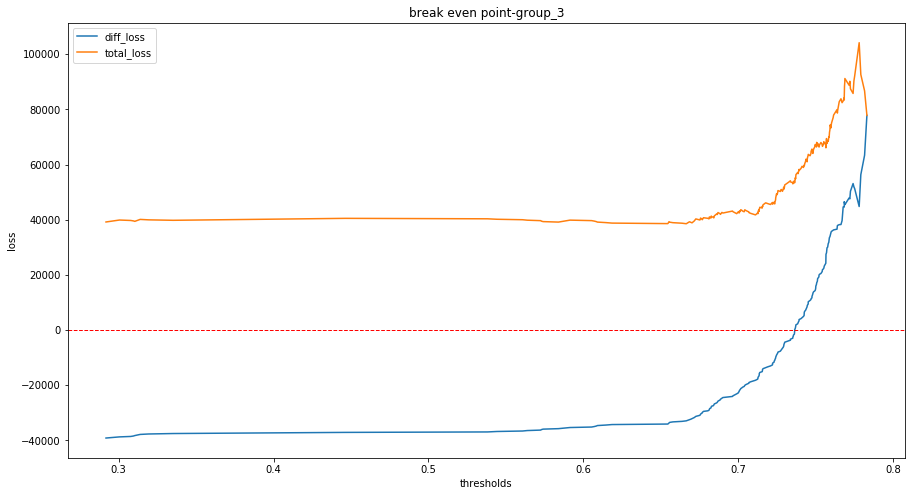

In [29]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_3')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 3에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

#### 그룹 4 - 높은 요금제 + 긴 임기

In [30]:
data = group_4.drop('Churn',axis=1)
target = group_4.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.9min finished


Accuracy : 0.631854
Precision : 0.348958
Recall : 0.807229
F1 score : 0.487273
F1.5 score : 0.574917
F2 score : 0.639313
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 67  16]
 [125 175]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 15112.67014만원
정밀도 오류에 따른 손해 : 53177.08333만원
차이 : 38064.41319


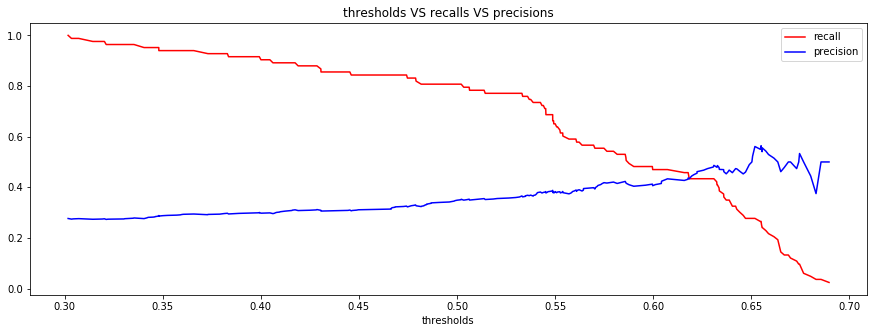

In [31]:
y_pred = grid_result.predict(X_val)

probs = grid_result.predict_proba(X_val)
y_prob = probs[:,1]

scr = evaluate(y_val,y_pred,y_prob)
loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
precision_recall_thresholds(y_val, y_prob)

In [32]:
loss_1 = []
loss_2 = []
precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
for k in range(len(thresholds)):
    for i in range(len(y_prob)):
        if y_prob[i]>=thresholds[k]:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    scr = evaluate(y_val,y_pred, y_prob)
    diff_loss, total_loss = loss_point(num = group1_num, charge = group1_MC, tenure = group1_TN, sol_price = price, recall = scr[2], precision = scr[1])
    loss_1.append(diff_loss)
    loss_2.append(total_loss)
loss_1 = np.array(loss_1)
loss_2 = np.array(loss_2)

Accuracy : 0.433420
Precision : 0.276667
Recall : 1.000000
F1 score : 0.433420
F1.5 score : 0.554186
F2 score : 0.656646
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 83   0]
 [217  83]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 0.0만원
정밀도 오류에 따른 손해 : 59081.86667만원
차이 : 59081.86667
Accuracy : 0.430809
Precision : 0.274247
Recall : 0.987952
F1 score : 0.429319
F1.5 score : 0.548636
F2 score : 0.649762
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 82   1]
 [217  83]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 944.54188만원
정밀도 오류에 따른 손해 : 59279.46488만원
차이 : 58334.92300
Accuracy : 0.433420
Precision : 0.275168
Recall : 0.987952
F1 score : 0.430446
F1.5 score : 0.549768
F2 score : 0.650794
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 82   1]
 [216  84]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 944.54188만원
정밀도 오류에 따른 손해 : 59204.2953만원
차이 : 58259.75342
Accuracy : 0.436031
Precision : 0.276094
Recall : 0.9

Accuracy : 0.480418
Precision : 0.288321
Recall : 0.951807
F1 score : 0.442577
F1.5 score : 0.557244
F2 score : 0.651815
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 79   4]
 [195 105]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 3778.16754만원
정밀도 오류에 따른 손해 : 58129.92701만원
차이 : 54351.75947
Accuracy : 0.477807
Precision : 0.285714
Recall : 0.939759
F1 score : 0.438202
F1.5 score : 0.551387
F2 score : 0.644628
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 78   5]
 [195 105]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 4722.70942만원
정밀도 오류에 따른 손해 : 58342.85714만원
차이 : 53620.14772
Accuracy : 0.480418
Precision : 0.286765
Recall : 0.939759
F1 score : 0.439437
F1.5 score : 0.552589
F2 score : 0.645695
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 78   5]
 [194 106]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 4722.70942만원
정밀도 오류에 따른 손해 : 58257.05882만원
차이 : 53534.34940
Accuracy : 0.483029
Precision : 0.287823
Re


Confusion Matrix : 
 [[ 74   9]
 [166 134]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 8500.87696만원
정밀도 오류에 따른 손해 : 56495.33333만원
차이 : 47994.45637
Accuracy : 0.545692
Precision : 0.309623
Recall : 0.891566
F1 score : 0.459627
F1.5 score : 0.564885
F2 score : 0.647986
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 74   9]
 [165 135]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 8500.87696만원
정밀도 오류에 따른 손해 : 56389.95816만원
차이 : 47889.08120
Accuracy : 0.548303
Precision : 0.310924
Recall : 0.891566
F1 score : 0.461059
F1.5 score : 0.566215
F2 score : 0.649123
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 74   9]
 [164 136]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 8500.87696만원
정밀도 오류에 따른 손해 : 56283.69748만원
차이 : 47782.82052
Accuracy : 0.545692
Precision : 0.308017
Recall : 0.879518
F1 score : 0.456250
F1.5 score : 0.559882
F2 score : 0.641476
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 73  10]
 [164 136]

Accuracy : 0.597911
Precision : 0.326829
Recall : 0.807229
F1 score : 0.465278
F1.5 score : 0.555839
F2 score : 0.623836
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 67  16]
 [138 162]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 15112.67014만원
정밀도 오류에 따른 손해 : 54984.58537만원
차이 : 39871.91523
Accuracy : 0.600522
Precision : 0.328431
Recall : 0.807229
F1 score : 0.466899
F1.5 score : 0.557262
F2 score : 0.625000
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 67  16]
 [137 163]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 15112.67014만원
정밀도 오류에 따른 손해 : 54853.72549만원
차이 : 39741.05535
Accuracy : 0.605744
Precision : 0.331683
Recall : 0.807229
F1 score : 0.470175
F1.5 score : 0.560129
F2 score : 0.627341
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 67  16]
 [135 165]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 15112.67014만원
정밀도 오류에 따른 손해 : 54588.11881만원
차이 : 39475.44867
Accuracy : 0.608355
Precision : 0.333333

Accuracy : 0.668407
Precision : 0.369048
Recall : 0.746988
F1 score : 0.494024
F1.5 score : 0.568006
F2 score : 0.620000
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 62  21]
 [106 194]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 19835.37956만원
정밀도 오류에 따른 손해 : 51536.19048만원
차이 : 31700.81092
Accuracy : 0.665796
Precision : 0.365269
Recall : 0.734940
F1 score : 0.488000
F1.5 score : 0.560424
F2 score : 0.611222
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 61  22]
 [106 194]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 20779.92145만원
정밀도 오류에 따른 손해 : 51844.79042만원
차이 : 31064.86897
Accuracy : 0.668407
Precision : 0.367470
Recall : 0.734940
F1 score : 0.489960
F1.5 score : 0.562013
F2 score : 0.612450
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 61  22]
 [105 195]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 20779.92145만원
정밀도 오류에 따른 손해 : 51665.06024만원
차이 : 30885.13879
Accuracy : 0.671018
Precision : 0.369697

Accuracy : 0.699739
Precision : 0.378788
Recall : 0.602410
F1 score : 0.465116
F1.5 score : 0.509804
F2 score : 0.538793
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 50  33]
 [ 82 218]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 31169.88217만원
정밀도 오류에 따른 손해 : 50740.60606만원
차이 : 19570.72389
Accuracy : 0.697128
Precision : 0.374046
Recall : 0.590361
F1 score : 0.457944
F1.5 score : 0.501180
F2 score : 0.529158
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 49  34]
 [ 82 218]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 32114.42405만원
정밀도 오류에 따른 손해 : 51127.93893만원
차이 : 19013.51488
Accuracy : 0.699739
Precision : 0.376923
Recall : 0.590361
F1 score : 0.460094
F1.5 score : 0.502762
F2 score : 0.530303
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 49  34]
 [ 81 219]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 32114.42405만원
정밀도 오류에 따른 손해 : 50892.92308만원
차이 : 18778.49903
Accuracy : 0.702350
Precision : 0.379845


Confusion Matrix : 
 [[ 42  41]
 [ 59 241]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 38726.21724만원
정밀도 오류에 따른 손해 : 47714.05941만원
차이 : 8987.84217
Accuracy : 0.736292
Precision : 0.410000
Recall : 0.493976
F1 score : 0.448087
F1.5 score : 0.464690
F2 score : 0.474537
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 41  42]
 [ 59 241]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 39670.75912만원
정밀도 오류에 따른 손해 : 48191.2만원
차이 : 8520.44088
Accuracy : 0.733681
Precision : 0.404040
Recall : 0.481928
F1 score : 0.439560
F1.5 score : 0.454943
F2 score : 0.464037
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 40  43]
 [ 59 241]]
정밀도를 더 높여야 합니다.
재현율 오류에 따른 손해 : 40615.30101만원
정밀도 오류에 따른 손해 : 48677.9798만원
차이 : 8062.67879
Accuracy : 0.736292
Precision : 0.408163
Recall : 0.481928
F1 score : 0.441989
F1.5 score : 0.456541
F2 score : 0.465116
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 40  43]
 [ 58 242]]
정밀도

F1 score : 0.385714
F1.5 score : 0.360000
F2 score : 0.347044
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 27  56]
 [ 30 270]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 52894.3455만원
정밀도 오류에 따른 손해 : 42989.47368만원
차이 : 9904.87182만원
Accuracy : 0.775457
Precision : 0.472727
Recall : 0.313253
F1 score : 0.376812
F1.5 score : 0.349535
F2 score : 0.335917
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 26  57]
 [ 29 271]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 53838.88738만원
정밀도 오류에 따른 손해 : 43067.63636만원
차이 : 10771.25102만원
Accuracy : 0.772846
Precision : 0.462963
Recall : 0.301205
F1 score : 0.364964
F1.5 score : 0.337487
F2 score : 0.323834
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[ 25  58]
 [ 29 271]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 54783.42927만원
정밀도 오류에 따른 손해 : 43865.18519만원
차이 : 10918.24408만원
Accuracy : 0.770235
Precision : 0.452830
Recall : 0.289157
F1 score : 0.352941
F1.5 score : 0.3

Accuracy : 0.783290
Precision : 0.500000
Recall : 0.036145
F1 score : 0.067416
F1.5 score : 0.050584
F2 score : 0.044379
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[  3  80]
 [  3 297]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 75563.35071만원
정밀도 오류에 따른 손해 : 40840.0만원
차이 : 34723.35071만원
Accuracy : 0.783290
Precision : 0.500000
Recall : 0.024096
F1 score : 0.045977
F1.5 score : 0.034076
F2 score : 0.029762
PR curve_auc score : 0.420481
ROC curve_auc score : 0.756104

Confusion Matrix : 
 [[  2  81]
 [  2 298]]
재현율을 더 높여야 합니다.
재현율 오류에 따른 손해 : 76507.8926만원
정밀도 오류에 따른 손해 : 40840.0만원
차이 : 35667.89260만원


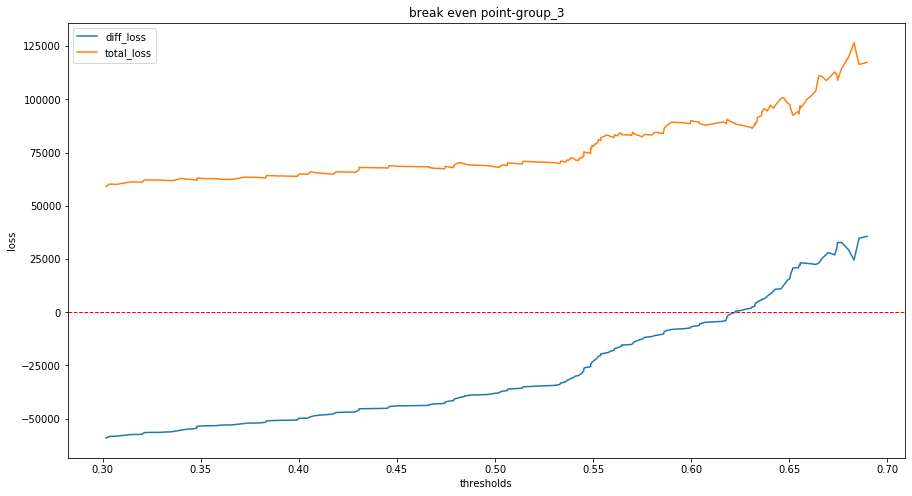

In [33]:
plt.figure(figsize=(15,8))
plt.title('break even point-group_3')
plt.xlabel('thresholds')
plt.ylabel('loss')
plt.plot(thresholds,loss_1, label = 'diff_loss')
plt.plot(thresholds,loss_2, label = 'total_loss')
plt.legend()
plt.axhline(y=0, color='r', linewidth=1, linestyle='--')

결론 : 집단 2에서는 재현율이 높을수록(그래프 왼쪽) 좋음, y=0인 지점이 마지노선(손익분기점)

최종 결론
손익분기점의 요소들을 내가 임의적으로 설정해서 그런지, 모든 그룹에서 재현율이 무작정 높기만 한 것이 무조건 좋게 나왔다.